# Baseline models training

Notebook contains training and validation of XGBoost models without any previous experiments on data.  We check 4 different prediction cases:
- All cancer types together, multiclass classification (stages: I, II, III, IV)
- All cancer types together, binary classification (stages: I-III vs IV)
- Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)
- Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

Outcomes can be treated as baseline results.

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [3]:
output_dir_multiclass = '../results/updated_data/stable_features/baseline_models/multiclass/'
output_dir_binary = '../results/updated_data/stable_features/baseline_models/binary/'

Load training data

In [4]:
data_path = '../data/cleaned/updated/stable_features/'
models_path = '../models'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Columns: 762 entries, ID to NDUFA4
dtypes: float64(758), object(4)
memory usage: 5.1+ MB


Define functions for cross-validation in a stratified way: one for hyperparameters optimization (returns only mean score) and a second for validation of the model with best params (returns predictions)

In [5]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [6]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [7]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### All cancer types together, multiclass classification (stages: I, II, III, IV)

Extract cancer types and stages to perform cross validation in a stratified way

Remove unnecessary columns: ID, Group, Sex and Age

Encode labels

In [8]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

3    539
2    149
1    113
0     69
Name: Stage, dtype: int64

Since the classes are pretty imbalanced we use the weighted-average F1 metric for optimization

In [9]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:31:03,808] A new study created in memory with name: no-name-656b50bb-2d3e-4526-a7c8-8d388088fd01
[I 2023-10-21 12:31:14,014] Trial 0 finished with value: 0.2866788947083001 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.2657259759800563, 'subsample': 0.5037466879506438, 'colsample_bytree': 0.8242062512648025, 'gamma': 2.3020122998324286}. Best is trial 0 with value: 0.2866788947083001.
[I 2023-10-21 12:31:24,291] Trial 1 finished with value: 0.2739950902512075 and parameters: {'n_estimators': 77, 'max_depth': 3, 'learning_rate': 0.20939162365260797, 'subsample': 0.5106243918348463, 'colsample_bytree': 0.9386924591412091, 'gamma': 1.4984095807265685}. Best is trial 0 with value: 0.2866788947083001.
[I 2023-10-21 12:31:39,954] Trial 2 finished with value: 0.2937377580955624 and parameters: {'n_estimators': 115, 'max_depth': 5, 'learning_rate': 0.15259948693384573, 'subsample': 0.7772717958783671, 'colsample_bytree': 0.727499047406091, 'gamma': 2.

[I 2023-10-21 12:35:48,216] Trial 25 finished with value: 0.2893293466345168 and parameters: {'n_estimators': 23, 'max_depth': 4, 'learning_rate': 0.4162310625851083, 'subsample': 0.6392332814969045, 'colsample_bytree': 0.850303589287484, 'gamma': 3.4244944421830787}. Best is trial 23 with value: 0.31460293331665834.
[I 2023-10-21 12:35:55,126] Trial 26 finished with value: 0.2907078385466184 and parameters: {'n_estimators': 86, 'max_depth': 3, 'learning_rate': 0.33765817690777294, 'subsample': 0.6369326096418263, 'colsample_bytree': 0.7665670442534757, 'gamma': 2.5016820600990184}. Best is trial 23 with value: 0.31460293331665834.
[I 2023-10-21 12:36:07,840] Trial 27 finished with value: 0.2810208629866262 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.2854796696666649, 'subsample': 0.7588547976882833, 'colsample_bytree': 0.795975451877869, 'gamma': 2.7928128933733714}. Best is trial 23 with value: 0.31460293331665834.
[I 2023-10-21 12:36:17,466] Trial 28 fin

[I 2023-10-21 12:39:28,616] Trial 50 finished with value: 0.29340119549155785 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.4250078532693669, 'subsample': 0.5782490659372601, 'colsample_bytree': 0.7369437853907996, 'gamma': 2.731241162482689}. Best is trial 46 with value: 0.31900584849499686.
[I 2023-10-21 12:39:36,100] Trial 51 finished with value: 0.2890832788640836 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.37617038032124633, 'subsample': 0.5559769811167699, 'colsample_bytree': 0.8269504667676608, 'gamma': 3.082849356022633}. Best is trial 46 with value: 0.31900584849499686.
[I 2023-10-21 12:39:48,071] Trial 52 finished with value: 0.29416387221047335 and parameters: {'n_estimators': 99, 'max_depth': 7, 'learning_rate': 0.3315388305477311, 'subsample': 0.588001955800506, 'colsample_bytree': 0.7876616092332269, 'gamma': 2.39259517197854}. Best is trial 46 with value: 0.31900584849499686.
[I 2023-10-21 12:39:59,182] Trial 53 fini

[I 2023-10-21 12:43:06,454] Trial 75 finished with value: 0.28907042535390176 and parameters: {'n_estimators': 111, 'max_depth': 6, 'learning_rate': 0.44618540671281054, 'subsample': 0.576949133824222, 'colsample_bytree': 0.7182456015057734, 'gamma': 3.794464243682075}. Best is trial 65 with value: 0.32307326691138477.
[I 2023-10-21 12:43:13,769] Trial 76 finished with value: 0.2973549107672486 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.42537446619397573, 'subsample': 0.5294382462369716, 'colsample_bytree': 0.817072418064744, 'gamma': 3.4547413992072373}. Best is trial 65 with value: 0.32307326691138477.
[I 2023-10-21 12:43:24,483] Trial 77 finished with value: 0.2784569987667112 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.4620694658524927, 'subsample': 0.5479632518343059, 'colsample_bytree': 0.7892595826550881, 'gamma': 3.5695121117876614}. Best is trial 65 with value: 0.32307326691138477.
[I 2023-10-21 12:43:37,399] Trial 78 f

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [10]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.29      0.07      0.12        69
          II       0.26      0.09      0.13       113
         III       0.22      0.09      0.12       149
          IV       0.66      0.92      0.77       539

    accuracy                           0.60       870
   macro avg       0.36      0.29      0.29       870
weighted avg       0.50      0.60      0.52       870



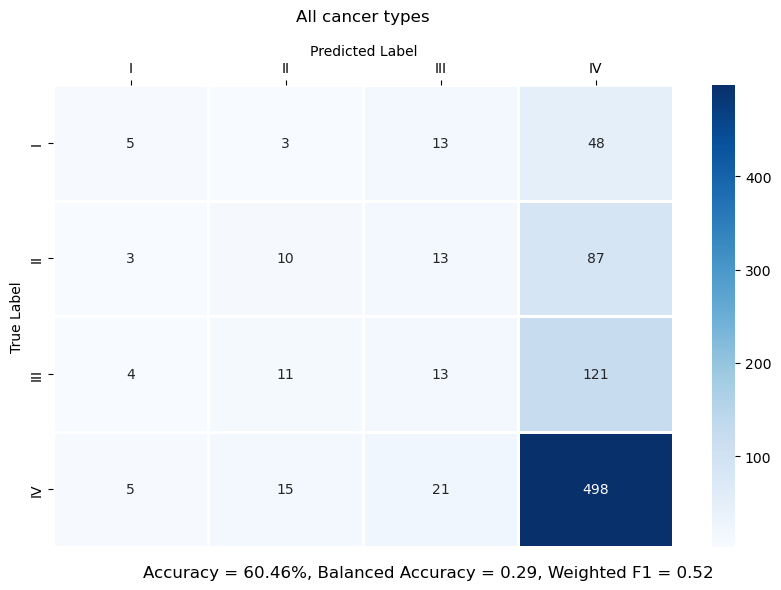

In [11]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'all_cancer_types.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

Check model performance for each cancer type separately

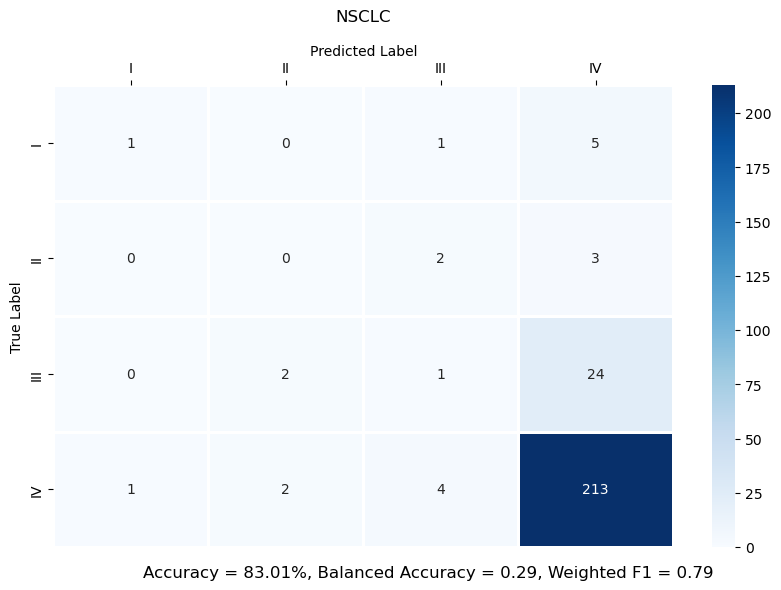

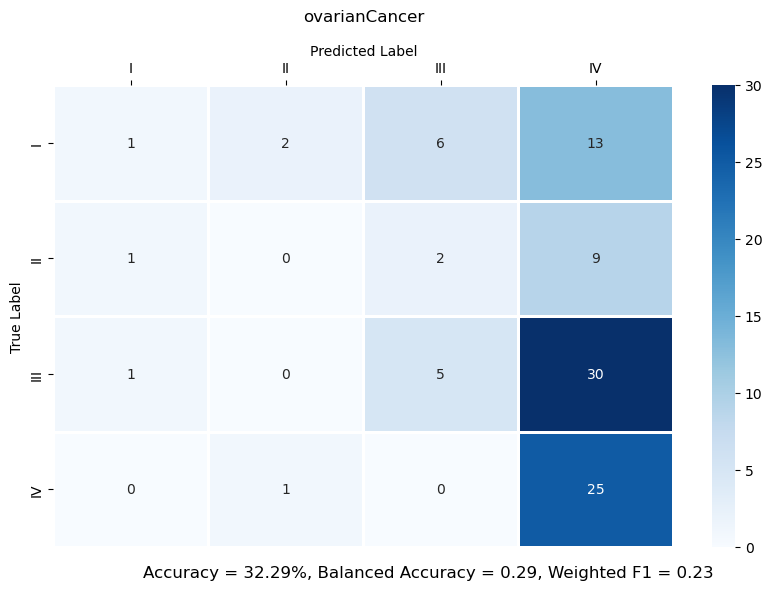

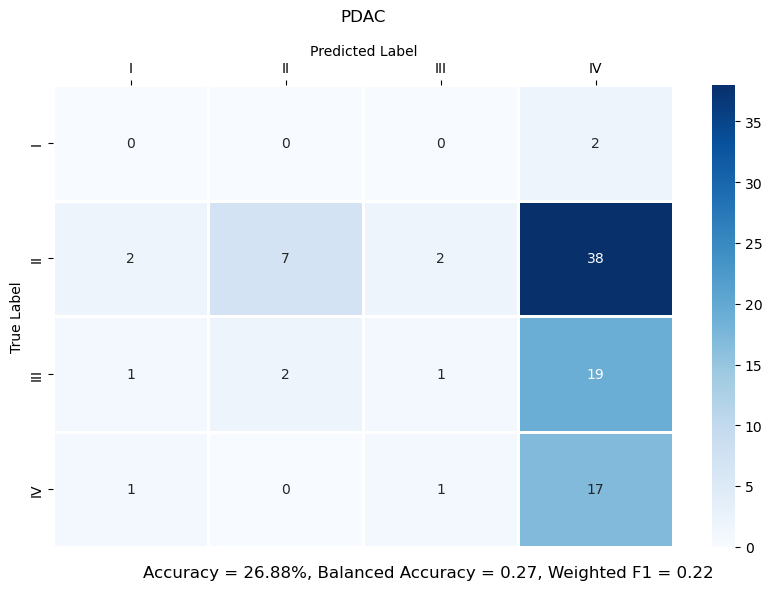

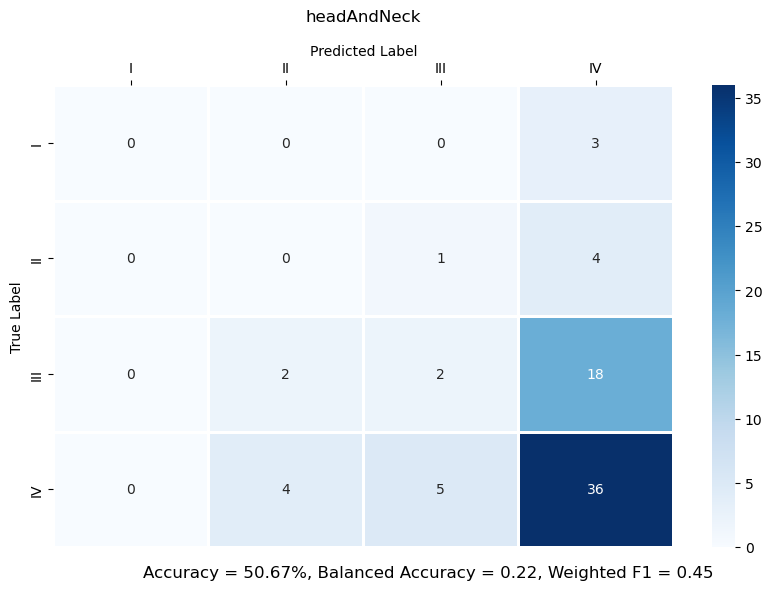

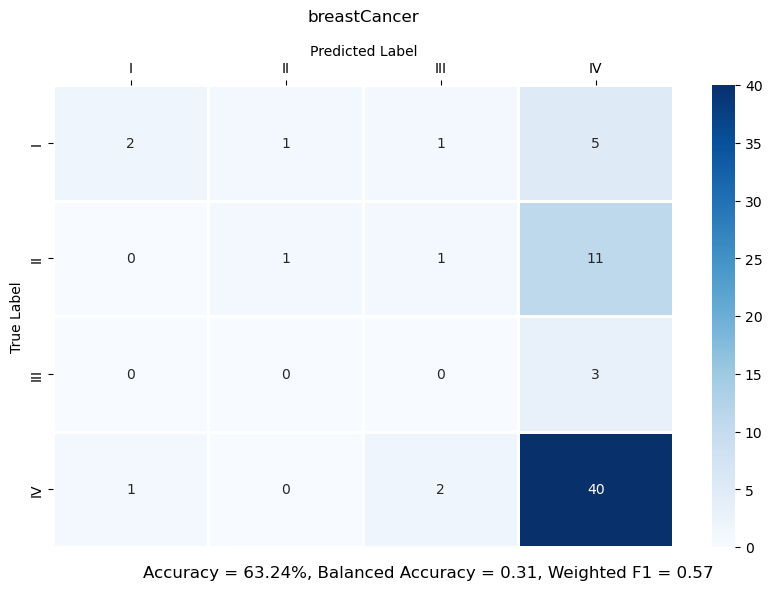

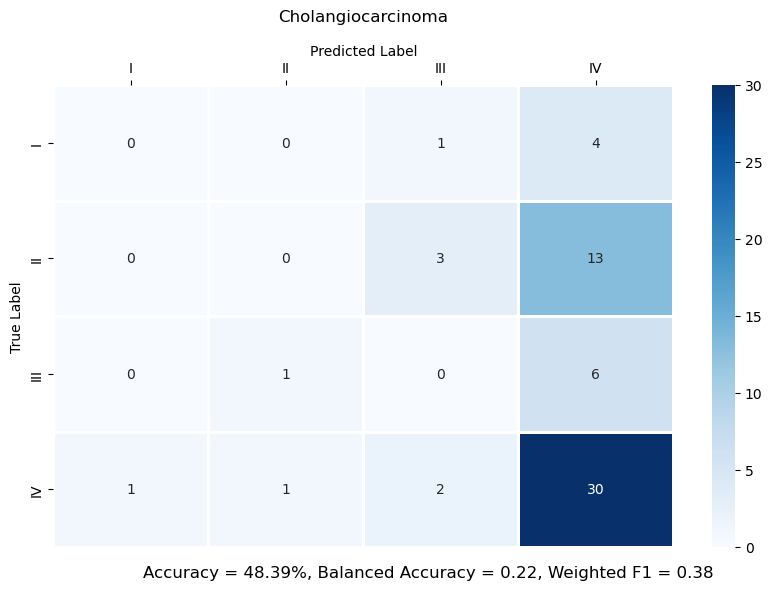

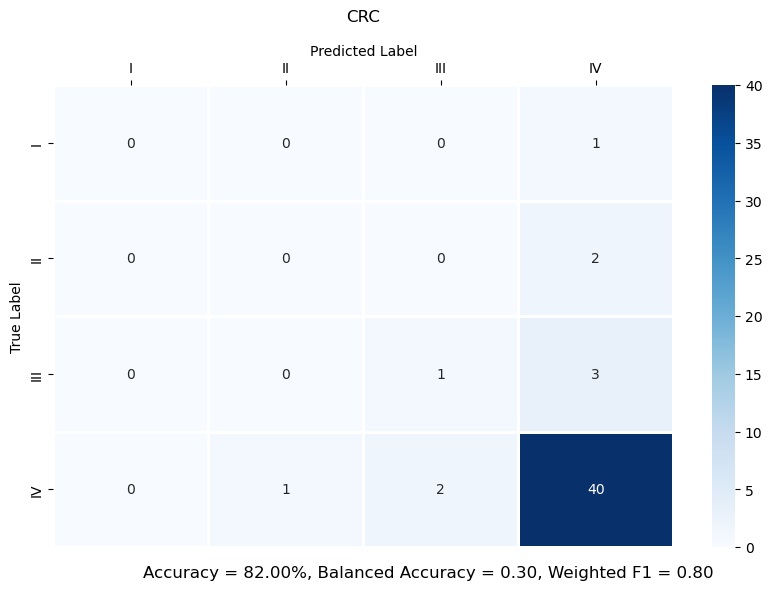

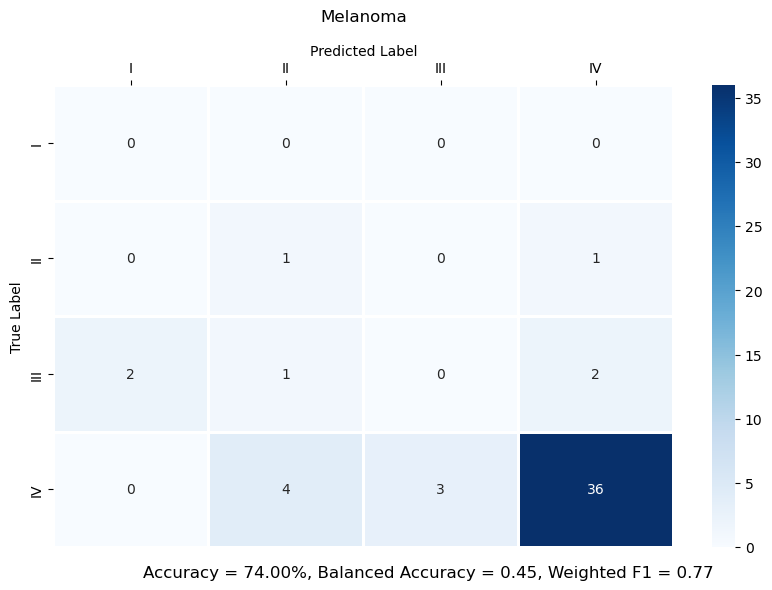

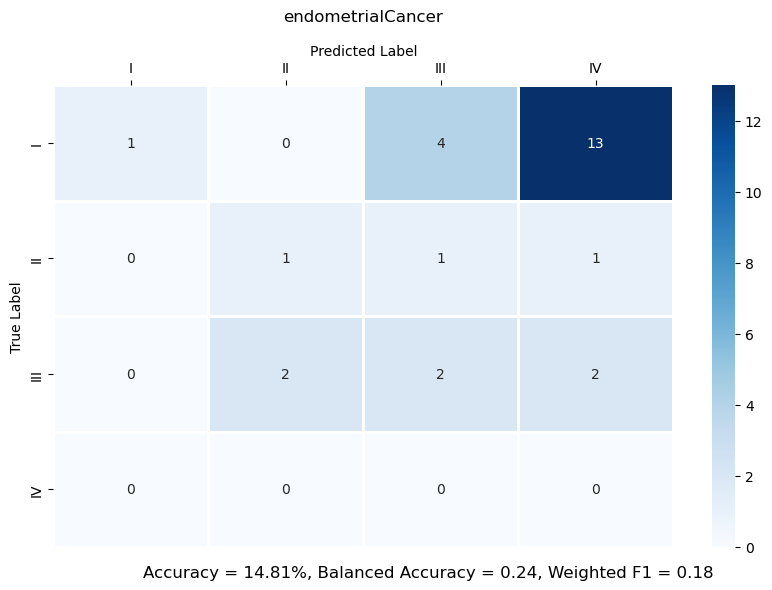

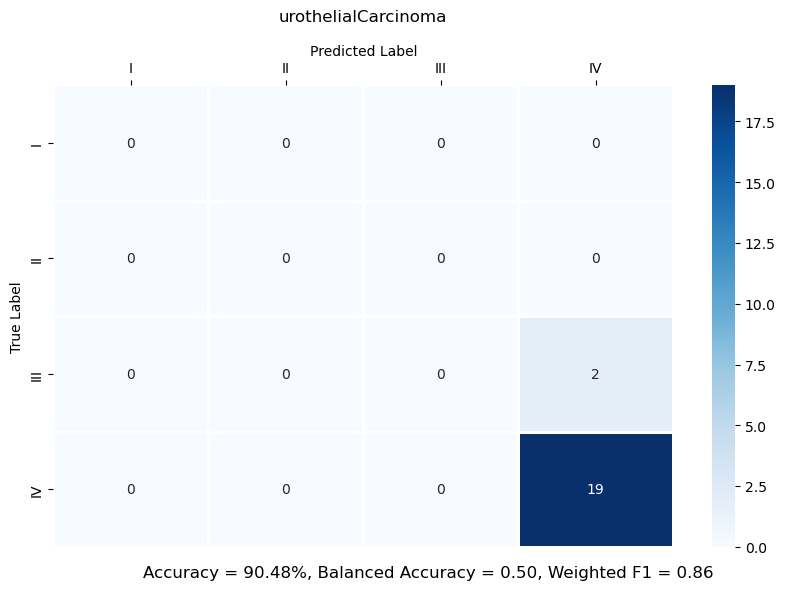

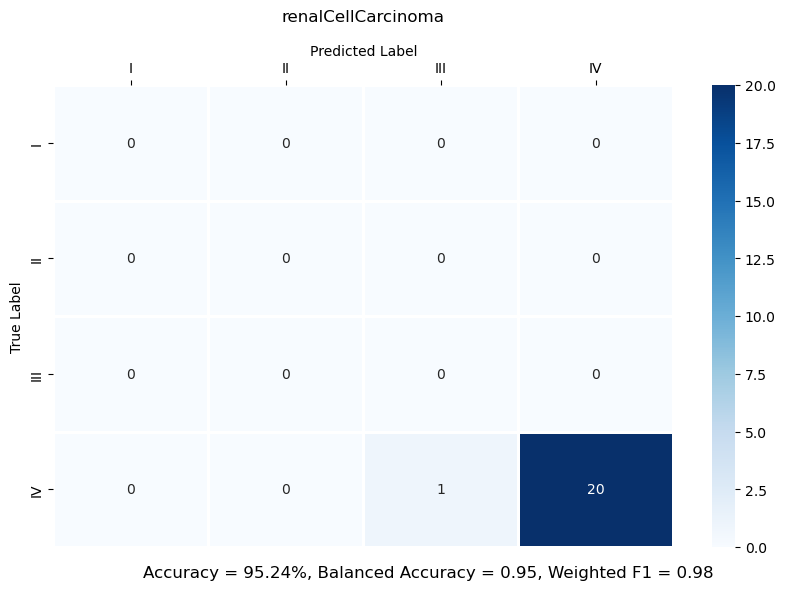

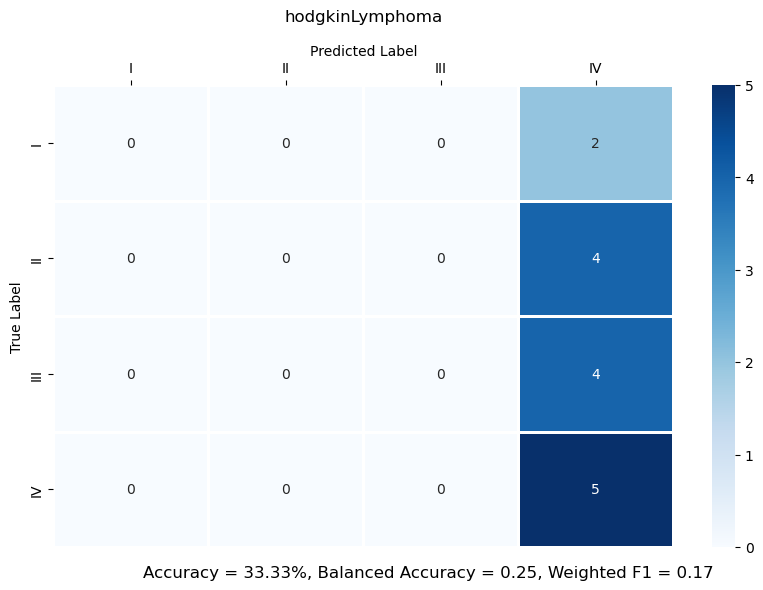

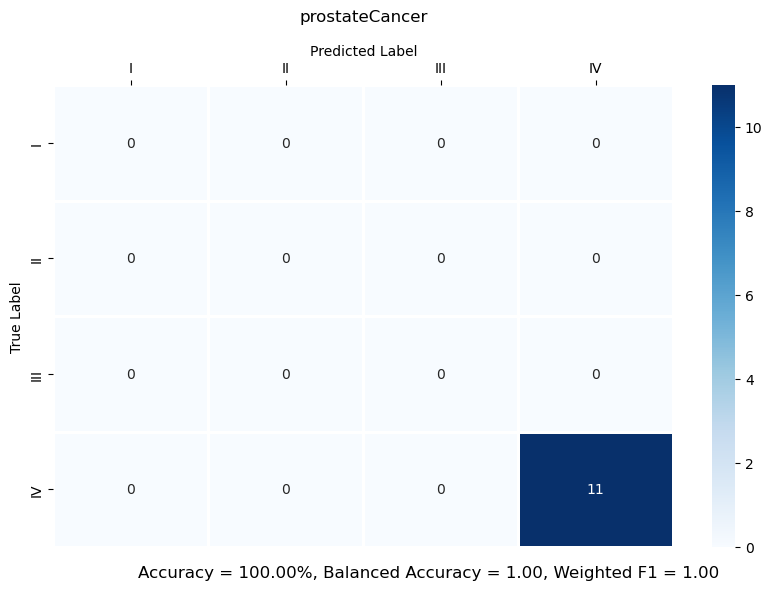

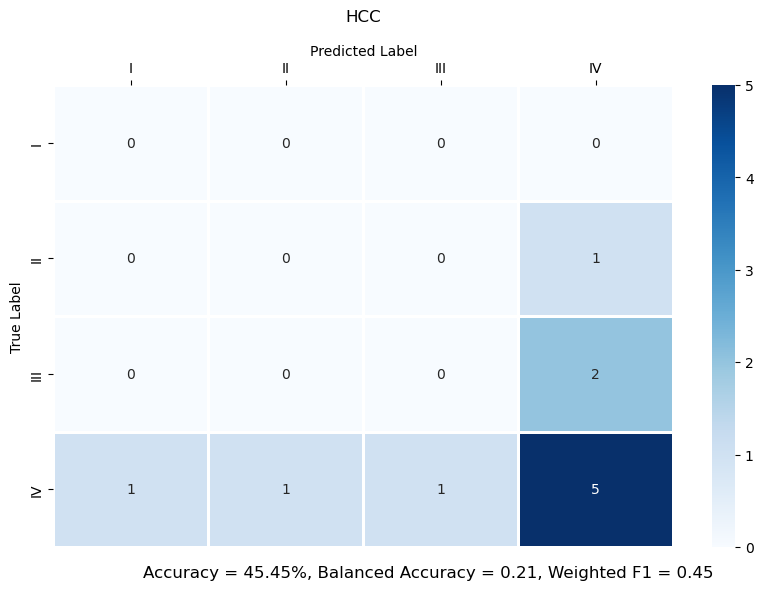

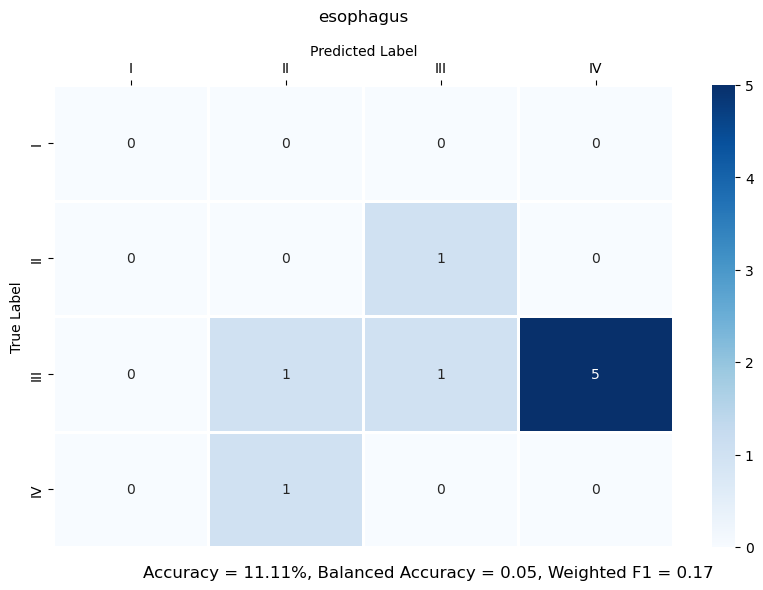

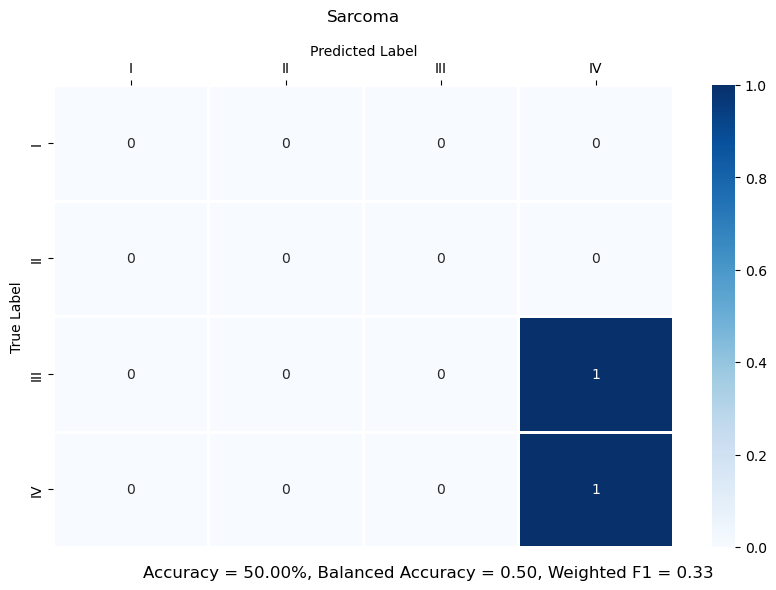

In [12]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'], average='weighted')
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1, 2, 3])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## All cancer types together, binary classification (stages: I-III vs IV)

Map first three stages to one mutual class "I-III"

Encode labels

In [13]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I-III': 0,
    'IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

1    539
0    331
Name: Stage, dtype: int64

Run hyperparameters optimization

In [14]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:46:31,655] A new study created in memory with name: no-name-10f11ed3-6621-4b21-88e0-0e731e19e01c
[I 2023-10-21 12:46:35,755] Trial 0 finished with value: 0.6166514014668734 and parameters: {'n_estimators': 88, 'max_depth': 5, 'learning_rate': 0.36118058539880316, 'subsample': 0.6280923096362495, 'colsample_bytree': 0.6018722831004851, 'gamma': 2.8374102407497794}. Best is trial 0 with value: 0.6166514014668734.
[I 2023-10-21 12:46:40,175] Trial 1 finished with value: 0.617539818506998 and parameters: {'n_estimators': 129, 'max_depth': 4, 'learning_rate': 0.3650259301671326, 'subsample': 0.9514739647757113, 'colsample_bytree': 0.5406964485335011, 'gamma': 4.554953288073477}. Best is trial 1 with value: 0.617539818506998.
[I 2023-10-21 12:46:46,910] Trial 2 finished with value: 0.6421245627908002 and parameters: {'n_estimators': 64, 'max_depth': 6, 'learning_rate': 0.07080988260269468, 'subsample': 0.8892447294856778, 'colsample_bytree': 0.7580617108363035, 'gamma': 1.45

[I 2023-10-21 12:48:35,381] Trial 25 finished with value: 0.6343005595344152 and parameters: {'n_estimators': 124, 'max_depth': 7, 'learning_rate': 0.1275290687190277, 'subsample': 0.6099288672308253, 'colsample_bytree': 0.8009907788797913, 'gamma': 1.8741820339879416}. Best is trial 4 with value: 0.6635261085568005.
[I 2023-10-21 12:48:40,227] Trial 26 finished with value: 0.6493795232313092 and parameters: {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.07047764695973133, 'subsample': 0.7320292431342821, 'colsample_bytree': 0.6373995329926629, 'gamma': 1.0624223268155124}. Best is trial 4 with value: 0.6635261085568005.
[I 2023-10-21 12:48:44,297] Trial 27 finished with value: 0.644173794348685 and parameters: {'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.046280370996124906, 'subsample': 0.6594586353909027, 'colsample_bytree': 0.5751320057727516, 'gamma': 2.5190574783716446}. Best is trial 4 with value: 0.6635261085568005.
[I 2023-10-21 12:48:47,611] Trial 28 finis

[I 2023-10-21 12:50:24,862] Trial 50 finished with value: 0.6484503506547546 and parameters: {'n_estimators': 130, 'max_depth': 2, 'learning_rate': 0.03950015077407602, 'subsample': 0.8380453669227227, 'colsample_bytree': 0.5817554972901697, 'gamma': 0.7097382333466065}. Best is trial 37 with value: 0.6787773161929002.
[I 2023-10-21 12:50:28,704] Trial 51 finished with value: 0.6549307733758328 and parameters: {'n_estimators': 107, 'max_depth': 3, 'learning_rate': 0.11640283830969293, 'subsample': 0.7808537535113715, 'colsample_bytree': 0.6250844056230759, 'gamma': 0.45067426943414207}. Best is trial 37 with value: 0.6787773161929002.
[I 2023-10-21 12:50:33,883] Trial 52 finished with value: 0.6573017312084024 and parameters: {'n_estimators': 116, 'max_depth': 4, 'learning_rate': 0.09490426975331115, 'subsample': 0.7591370025740333, 'colsample_bytree': 0.5931862083626229, 'gamma': 1.1143728238441284}. Best is trial 37 with value: 0.6787773161929002.
[I 2023-10-21 12:50:38,454] Trial 53

[I 2023-10-21 12:52:15,546] Trial 75 finished with value: 0.6502695920874876 and parameters: {'n_estimators': 123, 'max_depth': 3, 'learning_rate': 0.06958829174154557, 'subsample': 0.8471744082051077, 'colsample_bytree': 0.5800110817504215, 'gamma': 0.9286944270194405}. Best is trial 37 with value: 0.6787773161929002.
[I 2023-10-21 12:52:19,009] Trial 76 finished with value: 0.6698048836169599 and parameters: {'n_estimators': 134, 'max_depth': 2, 'learning_rate': 0.1305645233901026, 'subsample': 0.8107454562420815, 'colsample_bytree': 0.5607402889281909, 'gamma': 0.7199624195042165}. Best is trial 37 with value: 0.6787773161929002.
[I 2023-10-21 12:52:22,588] Trial 77 finished with value: 0.6539391119130733 and parameters: {'n_estimators': 134, 'max_depth': 2, 'learning_rate': 0.12733567319927863, 'subsample': 0.8005539265170916, 'colsample_bytree': 0.5561037793711124, 'gamma': 0.7364768207249026}. Best is trial 37 with value: 0.6787773161929002.
[I 2023-10-21 12:52:26,659] Trial 78 f

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [15]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.64      0.51      0.57       331
          IV       0.73      0.82      0.78       539

    accuracy                           0.71       870
   macro avg       0.69      0.67      0.67       870
weighted avg       0.70      0.71      0.70       870



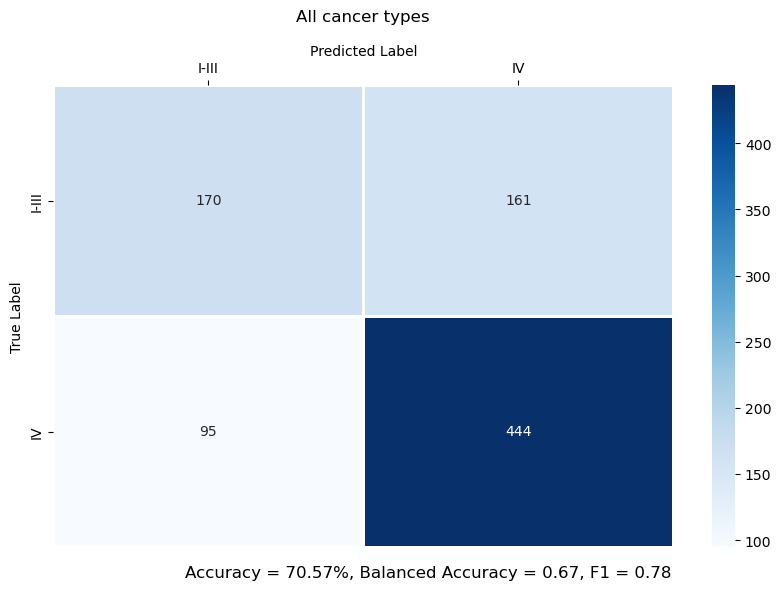

In [16]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

filename = f'all_cancer_types.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

Check model performance for each cancer type separately

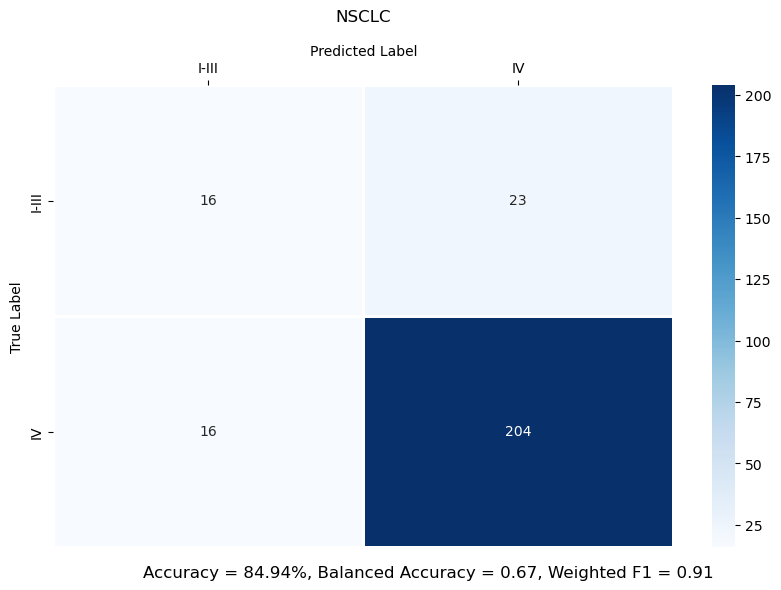

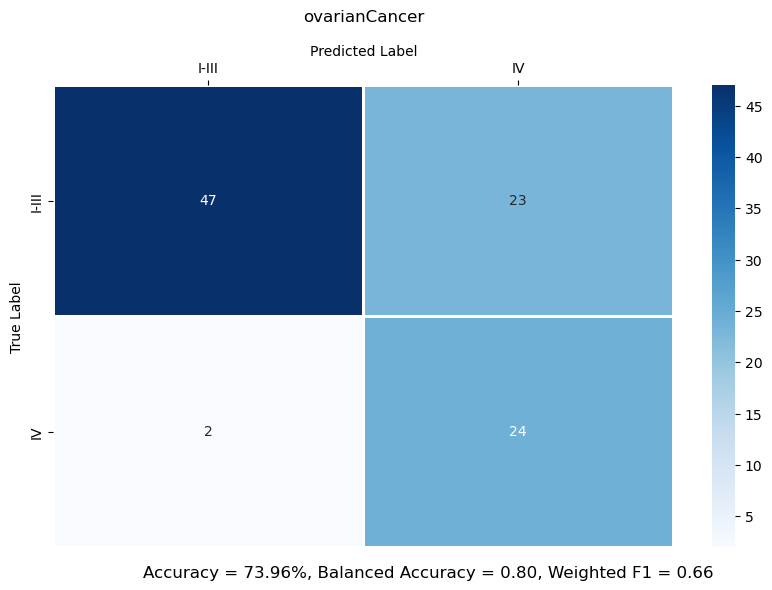

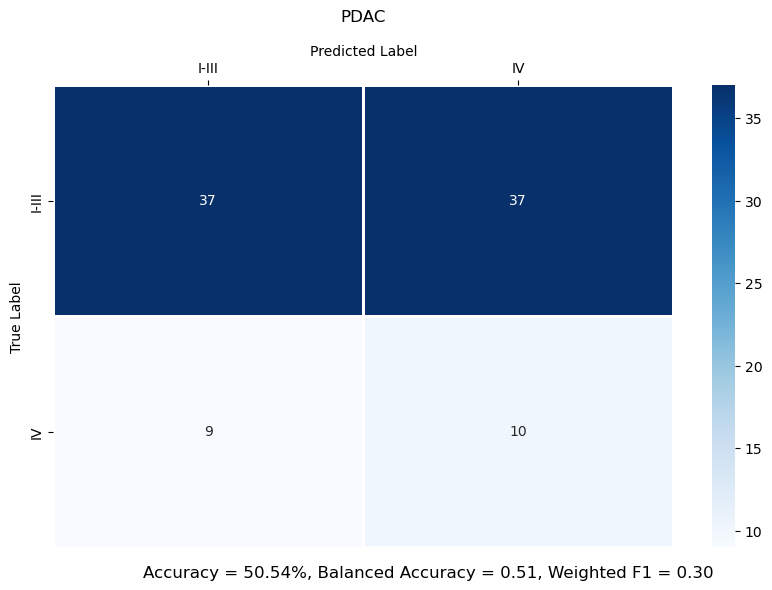

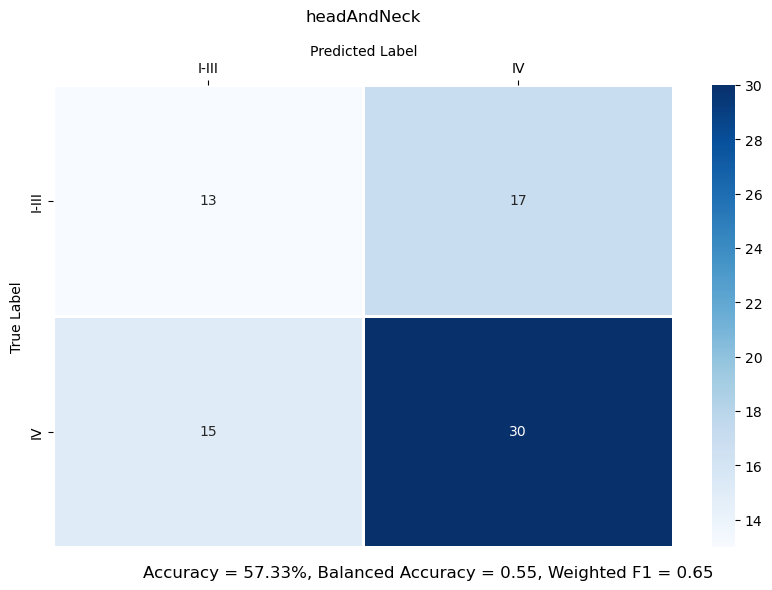

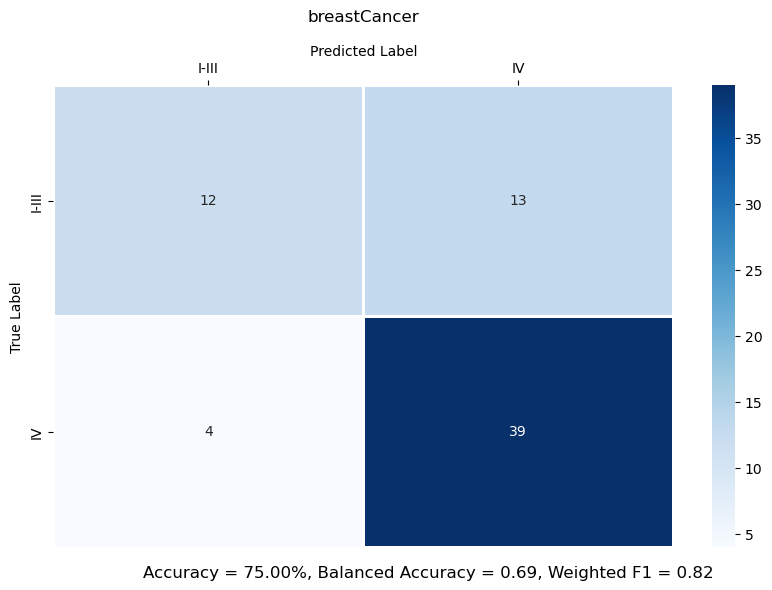

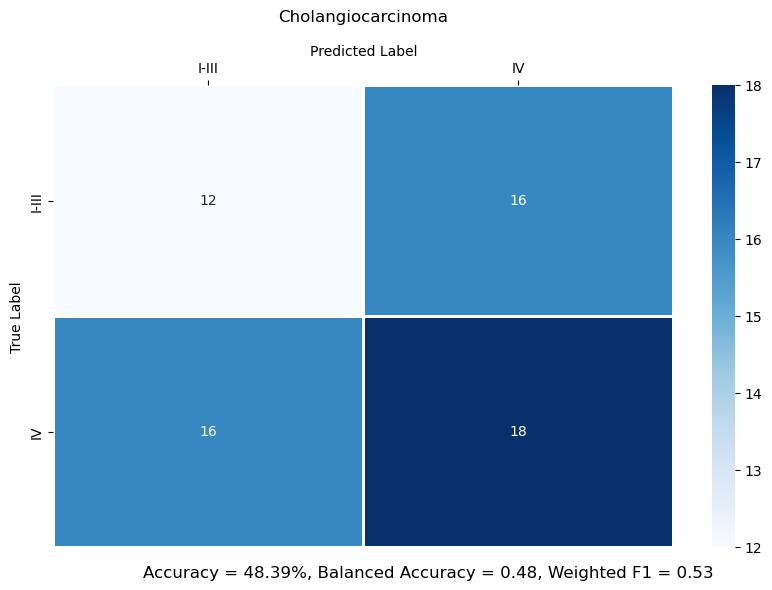

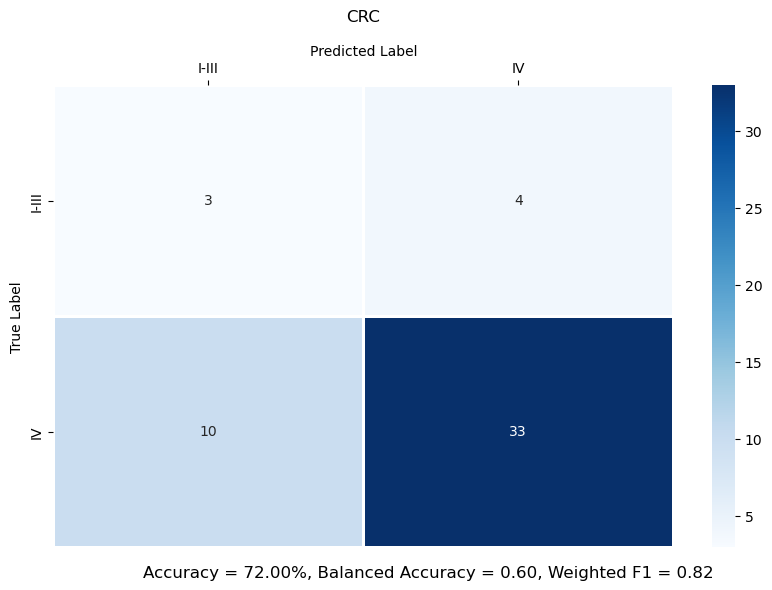

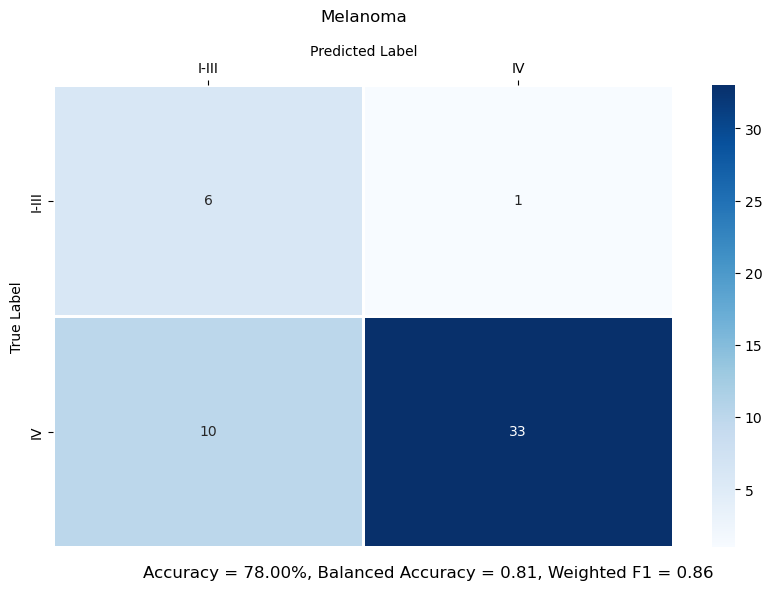

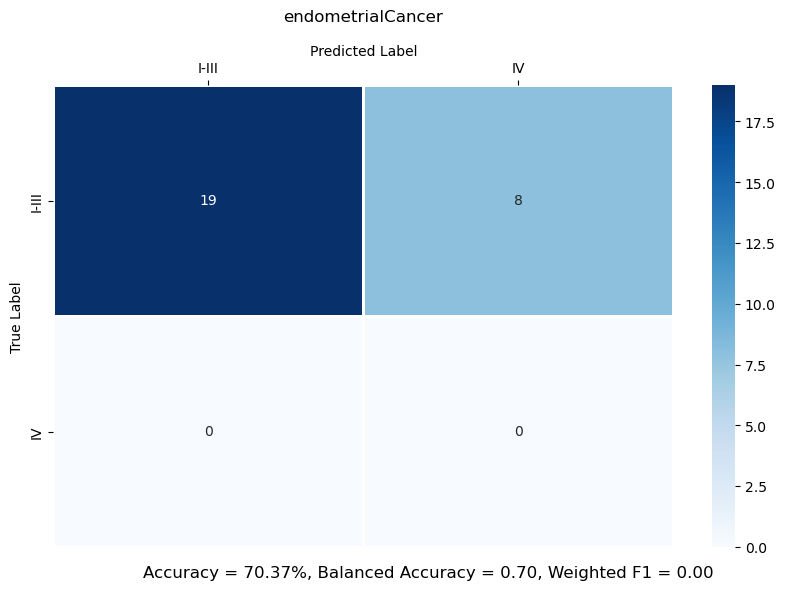

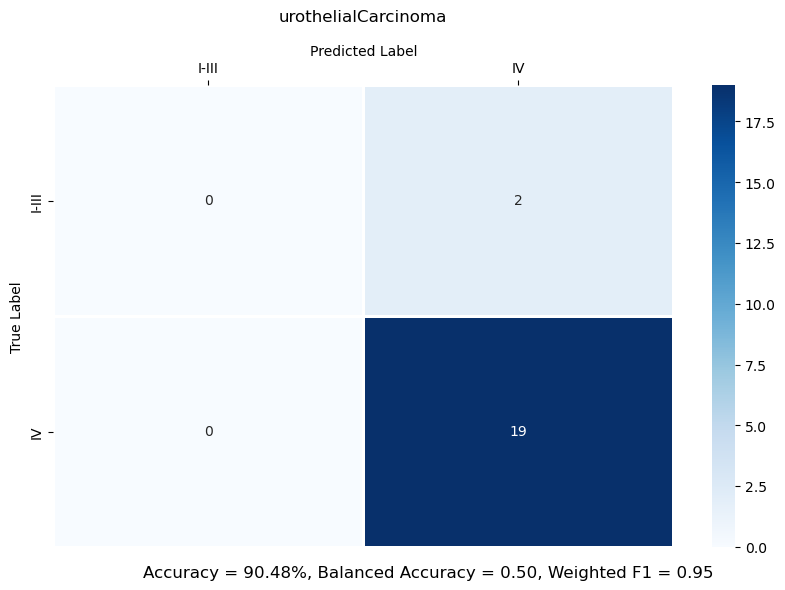

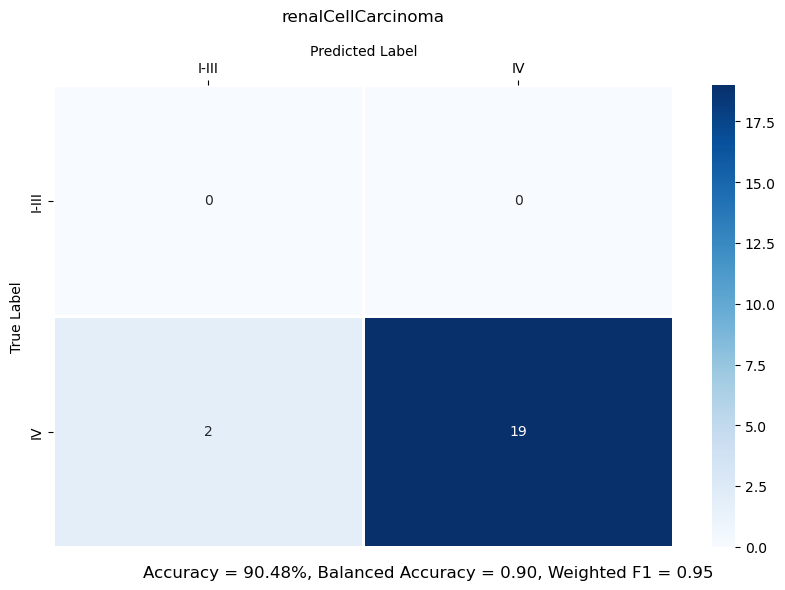

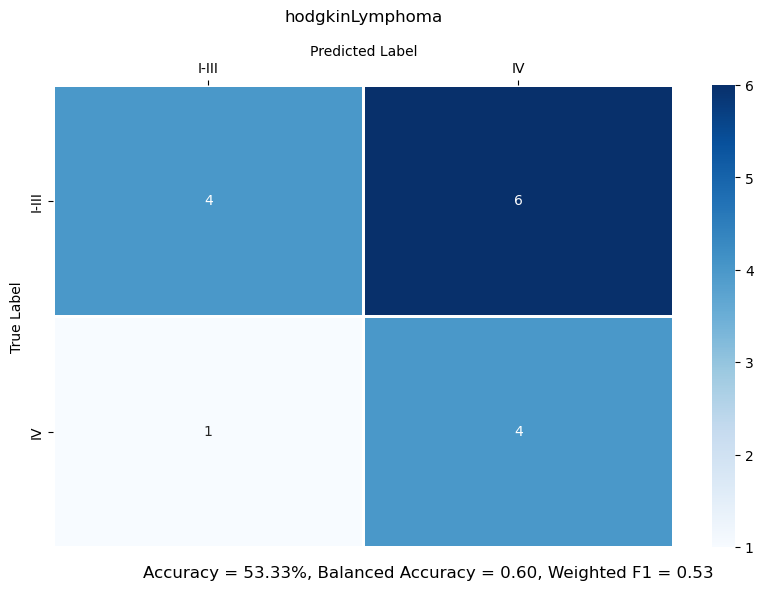

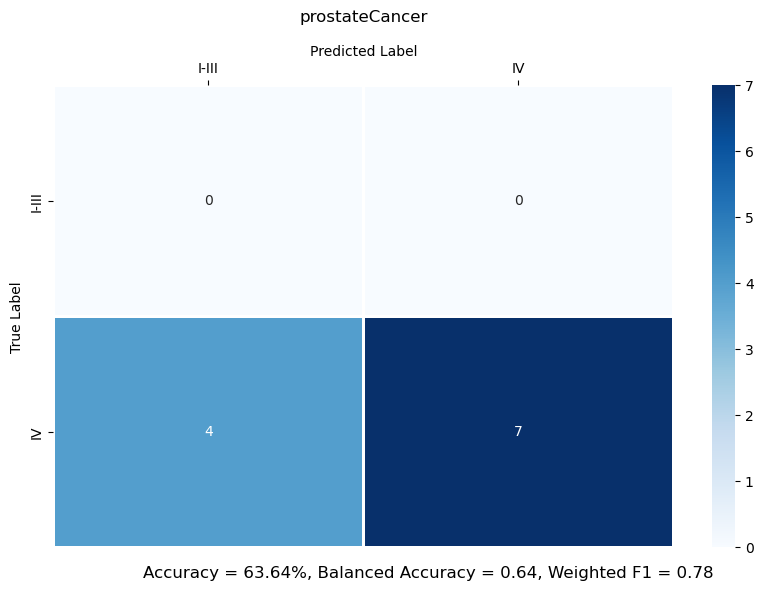

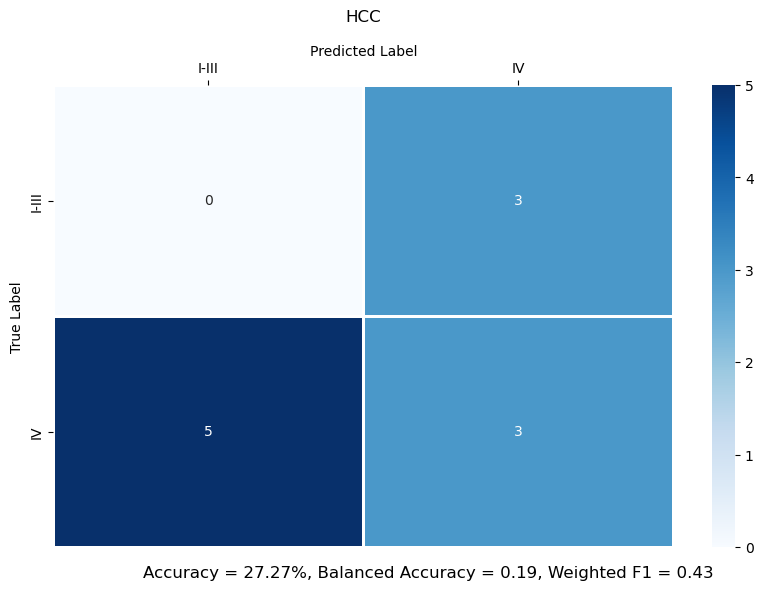

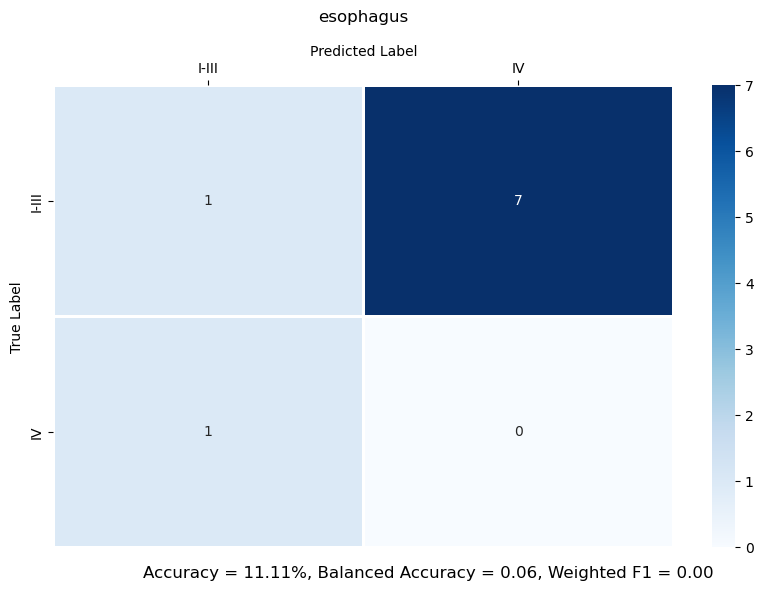

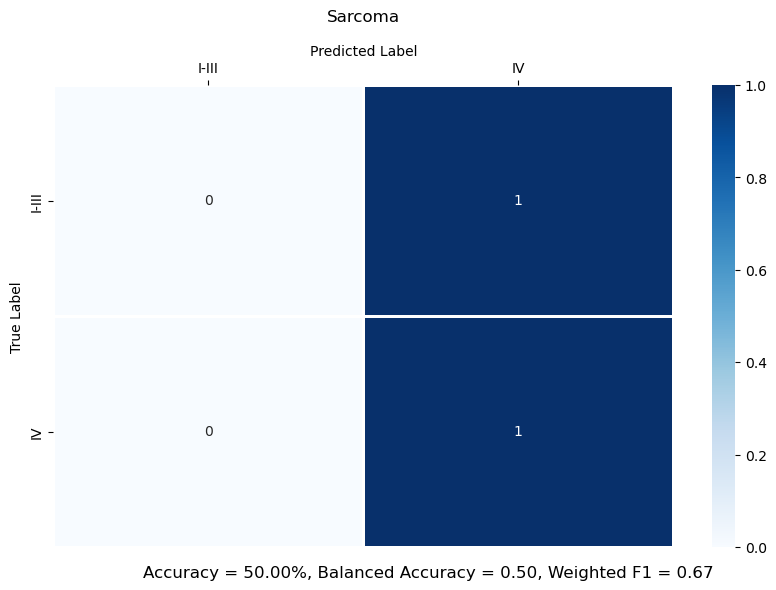

In [17]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'])
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)

In [18]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'num_class': 4,
}

scoring_func = balanced_accuracy_score

Get only the most numerous cancer types (with more than 90 cases)

In [19]:
cancer_type_counts = train['Group'].value_counts()
numerous_cancer_types = cancer_type_counts[cancer_type_counts > 90].index.tolist()
numerous_cancer_types

['NSCLC', 'ovarianCancer', 'PDAC']

For each cancer type a separate model will be created, optimized and tested

### NSCLC

In [20]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

3    220
2     27
0      7
1      5
Name: Stage, dtype: int64

In [21]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:54:01,076] A new study created in memory with name: no-name-cd15c5da-662d-445e-a0b1-437e360d37f3
[I 2023-10-21 12:54:07,141] Trial 0 finished with value: 0.2901785714285714 and parameters: {'n_estimators': 87, 'max_depth': 7, 'learning_rate': 0.06342910354097975, 'subsample': 0.6197519466842795, 'colsample_bytree': 0.9309945760778546, 'gamma': 2.7138544759802423}. Best is trial 0 with value: 0.2901785714285714.
[I 2023-10-21 12:54:13,982] Trial 1 finished with value: 0.25 and parameters: {'n_estimators': 117, 'max_depth': 7, 'learning_rate': 0.2966305491265831, 'subsample': 0.9496876911053032, 'colsample_bytree': 0.7645234486118896, 'gamma': 1.4823139378345707}. Best is trial 0 with value: 0.2901785714285714.
[I 2023-10-21 12:54:19,331] Trial 2 finished with value: 0.2589285714285714 and parameters: {'n_estimators': 102, 'max_depth': 6, 'learning_rate': 0.2617022342071676, 'subsample': 0.8372612266994235, 'colsample_bytree': 0.6756249798186332, 'gamma': 2.5522366659467

[I 2023-10-21 12:55:44,490] Trial 25 finished with value: 0.3214285714285714 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.3305009903010194, 'subsample': 0.9557641573171133, 'colsample_bytree': 0.9634765270750308, 'gamma': 0.8043171043228647}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:55:48,026] Trial 26 finished with value: 0.3515422077922078 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.39991379181526004, 'subsample': 0.8784427104082184, 'colsample_bytree': 0.8305173643793946, 'gamma': 0.9616498651832146}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:55:51,218] Trial 27 finished with value: 0.3526785714285714 and parameters: {'n_estimators': 109, 'max_depth': 5, 'learning_rate': 0.4574517315639792, 'subsample': 0.957176005260907, 'colsample_bytree': 0.9057743502030227, 'gamma': 0.4099520852847769}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:55:53,236] Trial 28 fin

[I 2023-10-21 12:56:45,653] Trial 50 finished with value: 0.3191558441558442 and parameters: {'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.4998973055139395, 'subsample': 0.9229889606044024, 'colsample_bytree': 0.9154569417423154, 'gamma': 1.2647308861791342}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:56:47,738] Trial 51 finished with value: 0.3604707792207792 and parameters: {'n_estimators': 64, 'max_depth': 2, 'learning_rate': 0.48011248129305995, 'subsample': 0.9420041722442477, 'colsample_bytree': 0.9300908578713412, 'gamma': 0.16366808297297947}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:56:50,011] Trial 52 finished with value: 0.3292207792207792 and parameters: {'n_estimators': 72, 'max_depth': 2, 'learning_rate': 0.4987332461073934, 'subsample': 0.9449721348664286, 'colsample_bytree': 0.9524392662912353, 'gamma': 0.03311521644921728}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:56:51,680] Trial 53 fin

[I 2023-10-21 12:57:53,573] Trial 75 finished with value: 0.24772727272727274 and parameters: {'n_estimators': 121, 'max_depth': 5, 'learning_rate': 0.36720247922414995, 'subsample': 0.9194195184632612, 'colsample_bytree': 0.9865624534401717, 'gamma': 0.5923616461372534}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:57:55,603] Trial 76 finished with value: 0.3481331168831169 and parameters: {'n_estimators': 39, 'max_depth': 6, 'learning_rate': 0.4520785830553515, 'subsample': 0.9437086210897888, 'colsample_bytree': 0.9570093638072336, 'gamma': 0.0054882355974059105}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:57:58,961] Trial 77 finished with value: 0.3113636363636364 and parameters: {'n_estimators': 111, 'max_depth': 4, 'learning_rate': 0.3454463451433511, 'subsample': 0.970193478376286, 'colsample_bytree': 0.9797950065095903, 'gamma': 0.3621859415177865}. Best is trial 22 with value: 0.4051136363636364.
[I 2023-10-21 12:58:01,779] Trial 78 

In [22]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       1.00      0.29      0.44         7
          II       0.00      0.00      0.00         5
         III       0.25      0.04      0.06        27
          IV       0.86      0.99      0.92       220

    accuracy                           0.85       259
   macro avg       0.53      0.33      0.36       259
weighted avg       0.79      0.85      0.80       259



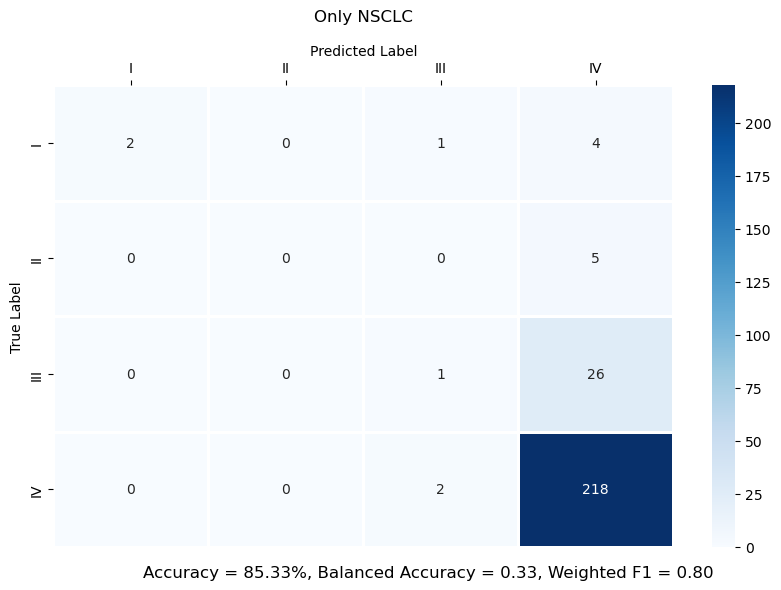

In [23]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Ovarian cancer

In [24]:
X_train = train.loc[train['Group'] == 'ovarianCancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

2    36
3    26
0    22
1    12
Name: Stage, dtype: int64

In [25]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 12:58:57,517] A new study created in memory with name: no-name-c03e40bc-ecac-4c8a-b1ac-af0c0a8d948f
[I 2023-10-21 12:58:59,075] Trial 0 finished with value: 0.3971230158730159 and parameters: {'n_estimators': 52, 'max_depth': 2, 'learning_rate': 0.1715431017854324, 'subsample': 0.9232639242369984, 'colsample_bytree': 0.8901260636041877, 'gamma': 3.6539091663260104}. Best is trial 0 with value: 0.3971230158730159.
[I 2023-10-21 12:59:01,081] Trial 1 finished with value: 0.4303571428571429 and parameters: {'n_estimators': 59, 'max_depth': 7, 'learning_rate': 0.08224902889104016, 'subsample': 0.5365854651647095, 'colsample_bytree': 0.9081472418652267, 'gamma': 2.8485859265802675}. Best is trial 1 with value: 0.4303571428571429.
[I 2023-10-21 12:59:03,159] Trial 2 finished with value: 0.4060515873015873 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.15031312250649148, 'subsample': 0.6916493570904968, 'colsample_bytree': 0.5332254650077164, 'gamma': 2.

[I 2023-10-21 12:59:59,966] Trial 25 finished with value: 0.4095238095238095 and parameters: {'n_estimators': 86, 'max_depth': 7, 'learning_rate': 0.15173368320588665, 'subsample': 0.9053305769928897, 'colsample_bytree': 0.7043390492841692, 'gamma': 1.7909407932618815}. Best is trial 3 with value: 0.45119047619047625.
[I 2023-10-21 13:00:01,598] Trial 26 finished with value: 0.40813492063492063 and parameters: {'n_estimators': 31, 'max_depth': 6, 'learning_rate': 0.0502408611410719, 'subsample': 0.8387534055027621, 'colsample_bytree': 0.63384874072684, 'gamma': 2.303283417834465}. Best is trial 3 with value: 0.45119047619047625.
[I 2023-10-21 13:00:03,540] Trial 27 finished with value: 0.4165674603174603 and parameters: {'n_estimators': 51, 'max_depth': 3, 'learning_rate': 0.09098333836098725, 'subsample': 0.9908910926140299, 'colsample_bytree': 0.7746703528236224, 'gamma': 1.1818741208833354}. Best is trial 3 with value: 0.45119047619047625.
[I 2023-10-21 13:00:05,829] Trial 28 finish

[I 2023-10-21 13:00:58,791] Trial 50 finished with value: 0.4129960317460318 and parameters: {'n_estimators': 86, 'max_depth': 2, 'learning_rate': 0.16494191104365233, 'subsample': 0.9997480987714736, 'colsample_bytree': 0.5772510788063309, 'gamma': 1.6891708837589143}. Best is trial 43 with value: 0.47202380952380957.
[I 2023-10-21 13:01:01,179] Trial 51 finished with value: 0.44216269841269845 and parameters: {'n_estimators': 68, 'max_depth': 2, 'learning_rate': 0.08474415548583893, 'subsample': 0.9277377523015327, 'colsample_bytree': 0.5484363302018661, 'gamma': 1.3877671878887978}. Best is trial 43 with value: 0.47202380952380957.
[I 2023-10-21 13:01:03,379] Trial 52 finished with value: 0.4234126984126984 and parameters: {'n_estimators': 73, 'max_depth': 2, 'learning_rate': 0.12085753868373725, 'subsample': 0.9177537334235015, 'colsample_bytree': 0.5259540056113512, 'gamma': 1.52963843973064}. Best is trial 43 with value: 0.47202380952380957.
[I 2023-10-21 13:01:05,896] Trial 53 f

[I 2023-10-21 13:01:59,779] Trial 75 finished with value: 0.4616071428571429 and parameters: {'n_estimators': 96, 'max_depth': 5, 'learning_rate': 0.05643573523224496, 'subsample': 0.9317166026808354, 'colsample_bytree': 0.6483499372297866, 'gamma': 0.9485392873400221}. Best is trial 43 with value: 0.47202380952380957.
[I 2023-10-21 13:02:02,679] Trial 76 finished with value: 0.4442460317460317 and parameters: {'n_estimators': 94, 'max_depth': 5, 'learning_rate': 0.05401164673515389, 'subsample': 0.9309774333704546, 'colsample_bytree': 0.6511346347340367, 'gamma': 0.9659671952954436}. Best is trial 43 with value: 0.47202380952380957.
[I 2023-10-21 13:02:05,435] Trial 77 finished with value: 0.4199404761904762 and parameters: {'n_estimators': 104, 'max_depth': 2, 'learning_rate': 0.03444992956390318, 'subsample': 0.9126518033627148, 'colsample_bytree': 0.6074046240475847, 'gamma': 1.8047000160593076}. Best is trial 43 with value: 0.47202380952380957.
[I 2023-10-21 13:02:08,770] Trial 78

In [26]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.33      0.27      0.30        22
          II       0.33      0.17      0.22        12
         III       0.35      0.44      0.39        36
          IV       0.69      0.69      0.69        26

    accuracy                           0.44        96
   macro avg       0.43      0.39      0.40        96
weighted avg       0.44      0.44      0.43        96



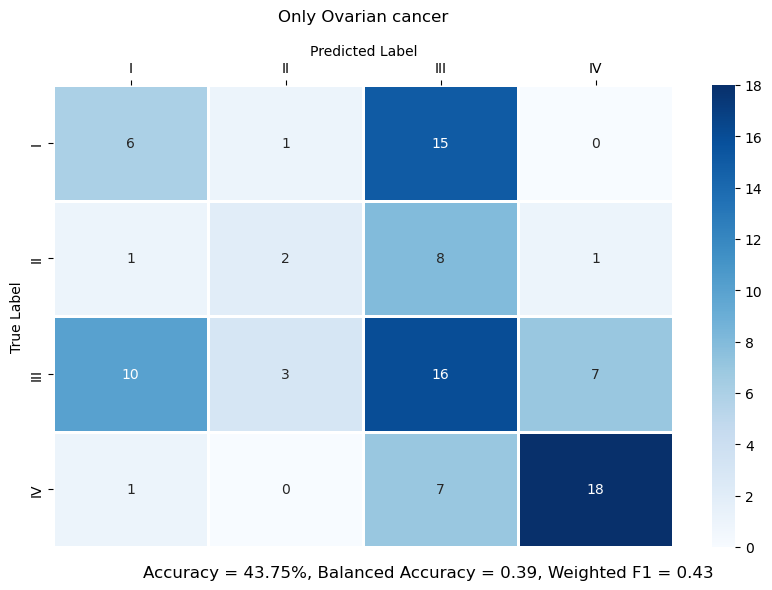

In [27]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### PDAC


In [28]:
X_train = train.loc[train['Group'] == 'PDAC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

1    49
2    23
3    19
0     2
Name: Stage, dtype: int64

In [29]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 13:03:05,359] A new study created in memory with name: no-name-d54df089-03e5-4555-9d43-9fb9c1a2cf7b
[I 2023-10-21 13:03:07,280] Trial 0 finished with value: 0.28806089743589747 and parameters: {'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.43330665708798083, 'subsample': 0.6746434136828985, 'colsample_bytree': 0.802505506292662, 'gamma': 2.450636993717938}. Best is trial 0 with value: 0.28806089743589747.
[I 2023-10-21 13:03:09,761] Trial 1 finished with value: 0.265892094017094 and parameters: {'n_estimators': 76, 'max_depth': 4, 'learning_rate': 0.2253064831776401, 'subsample': 0.5201283057557897, 'colsample_bytree': 0.6079190803495955, 'gamma': 0.1989533470338012}. Best is trial 0 with value: 0.28806089743589747.
[I 2023-10-21 13:03:10,979] Trial 2 finished with value: 0.30755876068376065 and parameters: {'n_estimators': 25, 'max_depth': 8, 'learning_rate': 0.315127069893123, 'subsample': 0.6977991914467129, 'colsample_bytree': 0.8337320910542803, 'gamma': 1.5

[I 2023-10-21 13:04:15,655] Trial 25 finished with value: 0.2685630341880342 and parameters: {'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.29511947731069316, 'subsample': 0.6659657482243744, 'colsample_bytree': 0.8613034630159745, 'gamma': 0.41833328193951214}. Best is trial 22 with value: 0.35878739316239316.
[I 2023-10-21 13:04:17,956] Trial 26 finished with value: 0.33261217948717947 and parameters: {'n_estimators': 82, 'max_depth': 2, 'learning_rate': 0.36500896896983615, 'subsample': 0.6145456698010089, 'colsample_bytree': 0.9537308031045757, 'gamma': 1.1325177737159835}. Best is trial 22 with value: 0.35878739316239316.
[I 2023-10-21 13:04:20,570] Trial 27 finished with value: 0.25854700854700857 and parameters: {'n_estimators': 83, 'max_depth': 2, 'learning_rate': 0.3570153946247238, 'subsample': 0.5422371743790247, 'colsample_bytree': 0.9358263486767072, 'gamma': 1.2793082288899393}. Best is trial 22 with value: 0.35878739316239316.
[I 2023-10-21 13:04:22,342] Trial 2

[I 2023-10-21 13:05:16,563] Trial 50 finished with value: 0.29302884615384617 and parameters: {'n_estimators': 63, 'max_depth': 5, 'learning_rate': 0.42543201875504527, 'subsample': 0.6942928158713942, 'colsample_bytree': 0.9745064975608955, 'gamma': 1.68026835556153}. Best is trial 37 with value: 0.3759081196581197.
[I 2023-10-21 13:05:18,862] Trial 51 finished with value: 0.29748931623931624 and parameters: {'n_estimators': 78, 'max_depth': 4, 'learning_rate': 0.4462386337966331, 'subsample': 0.5988600158127502, 'colsample_bytree': 0.8260033539732146, 'gamma': 1.4140027582125427}. Best is trial 37 with value: 0.3759081196581197.
[I 2023-10-21 13:05:21,408] Trial 52 finished with value: 0.3363782051282051 and parameters: {'n_estimators': 88, 'max_depth': 4, 'learning_rate': 0.3945572202424712, 'subsample': 0.5637064228307319, 'colsample_bytree': 0.7927768130044803, 'gamma': 1.1518598370253552}. Best is trial 37 with value: 0.3759081196581197.
[I 2023-10-21 13:05:23,157] Trial 53 finis

[I 2023-10-21 13:06:18,951] Trial 75 finished with value: 0.31137820512820513 and parameters: {'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.39473678017168357, 'subsample': 0.6338222640332112, 'colsample_bytree': 0.8366876233850395, 'gamma': 1.244531470881475}. Best is trial 37 with value: 0.3759081196581197.
[I 2023-10-21 13:06:21,140] Trial 76 finished with value: 0.3094551282051282 and parameters: {'n_estimators': 65, 'max_depth': 3, 'learning_rate': 0.4426926508420264, 'subsample': 0.595049309353097, 'colsample_bytree': 0.7834356322214646, 'gamma': 1.416156814063284}. Best is trial 37 with value: 0.3759081196581197.
[I 2023-10-21 13:06:24,470] Trial 77 finished with value: 0.2888087606837607 and parameters: {'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.4053331282254927, 'subsample': 0.615352075199828, 'colsample_bytree': 0.7984829794637717, 'gamma': 0.34590007818848}. Best is trial 37 with value: 0.3759081196581197.
[I 2023-10-21 13:06:27,847] Trial 78 finished 

In [30]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.53      0.80      0.63        49
         III       0.15      0.09      0.11        23
          IV       0.17      0.05      0.08        19

    accuracy                           0.45        93
   macro avg       0.21      0.23      0.21        93
weighted avg       0.35      0.45      0.38        93



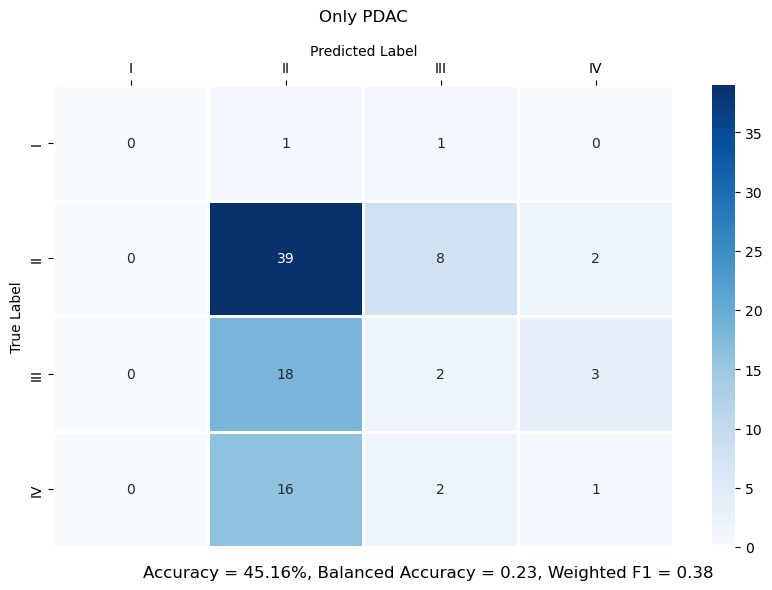

In [31]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pdac_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

In [32]:
mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}

labels_encoding = {
    'I-III': 0,
    'IV': 1
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}

### NSCLC

In [33]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

1    220
0     39
Name: Stage, dtype: int64

In [34]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 13:07:23,645] A new study created in memory with name: no-name-a0d4876b-fbfb-408c-a218-a450cc0e251b
[I 2023-10-21 13:07:26,093] Trial 0 finished with value: 0.5718434343434343 and parameters: {'n_estimators': 116, 'max_depth': 2, 'learning_rate': 0.05080771567803789, 'subsample': 0.6612764308382895, 'colsample_bytree': 0.7312654294826175, 'gamma': 0.09459080452777102}. Best is trial 0 with value: 0.5718434343434343.
[I 2023-10-21 13:07:27,983] Trial 1 finished with value: 0.5882575757575758 and parameters: {'n_estimators': 76, 'max_depth': 6, 'learning_rate': 0.4764902829616788, 'subsample': 0.8757041982275842, 'colsample_bytree': 0.6281043421301628, 'gamma': 3.8331283147464132}. Best is trial 1 with value: 0.5882575757575758.
[I 2023-10-21 13:07:29,208] Trial 2 finished with value: 0.6255050505050506 and parameters: {'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.05610121330165123, 'subsample': 0.958657246614818, 'colsample_bytree': 0.8082028877254916, 'gamma': 4

[I 2023-10-21 13:08:15,488] Trial 25 finished with value: 0.6116161616161615 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.00886919672090205, 'subsample': 0.8946468360949216, 'colsample_bytree': 0.9136497537911199, 'gamma': 3.675097603629278}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:08:17,417] Trial 26 finished with value: 0.6107323232323233 and parameters: {'n_estimators': 117, 'max_depth': 4, 'learning_rate': 0.34210371831706843, 'subsample': 0.9671069134716334, 'colsample_bytree': 0.9601249610865035, 'gamma': 4.472343334404252}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:08:19,073] Trial 27 finished with value: 0.5880050505050505 and parameters: {'n_estimators': 64, 'max_depth': 6, 'learning_rate': 0.25201415375944597, 'subsample': 0.9975186410380993, 'colsample_bytree': 0.7846076799534939, 'gamma': 2.396104347690855}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:08:20,392] Trial 28 finishe

[I 2023-10-21 13:08:54,611] Trial 50 finished with value: 0.6223484848484848 and parameters: {'n_estimators': 40, 'max_depth': 8, 'learning_rate': 0.42369383569843366, 'subsample': 0.9027807701086141, 'colsample_bytree': 0.9677827136619193, 'gamma': 3.828533414146081}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:08:55,951] Trial 51 finished with value: 0.6186868686868687 and parameters: {'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.4593278904610809, 'subsample': 0.9747699668918187, 'colsample_bytree': 0.9224552639298245, 'gamma': 3.339622221299615}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:08:57,219] Trial 52 finished with value: 0.5959595959595959 and parameters: {'n_estimators': 30, 'max_depth': 6, 'learning_rate': 0.4501348853138397, 'subsample': 0.9824448349333259, 'colsample_bytree': 0.9117008023202393, 'gamma': 3.2410169604545325}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:08:58,701] Trial 53 finished w

[I 2023-10-21 13:09:36,845] Trial 75 finished with value: 0.5868686868686869 and parameters: {'n_estimators': 39, 'max_depth': 7, 'learning_rate': 0.4351848760610466, 'subsample': 0.9835037405671556, 'colsample_bytree': 0.981036789238583, 'gamma': 3.49758162617553}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:09:38,066] Trial 76 finished with value: 0.6473484848484848 and parameters: {'n_estimators': 34, 'max_depth': 8, 'learning_rate': 0.4689812772180831, 'subsample': 0.920794282742408, 'colsample_bytree': 0.9451942766322002, 'gamma': 2.8298454373948223}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:09:39,325] Trial 77 finished with value: 0.6371212121212121 and parameters: {'n_estimators': 25, 'max_depth': 8, 'learning_rate': 0.44533371310337827, 'subsample': 0.9393655370601732, 'colsample_bytree': 0.9660896060015295, 'gamma': 3.071153035794942}. Best is trial 4 with value: 0.6589646464646465.
[I 2023-10-21 13:09:40,933] Trial 78 finished with

In [35]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.75      0.23      0.35        39
          IV       0.88      0.99      0.93       220

    accuracy                           0.87       259
   macro avg       0.81      0.61      0.64       259
weighted avg       0.86      0.87      0.84       259



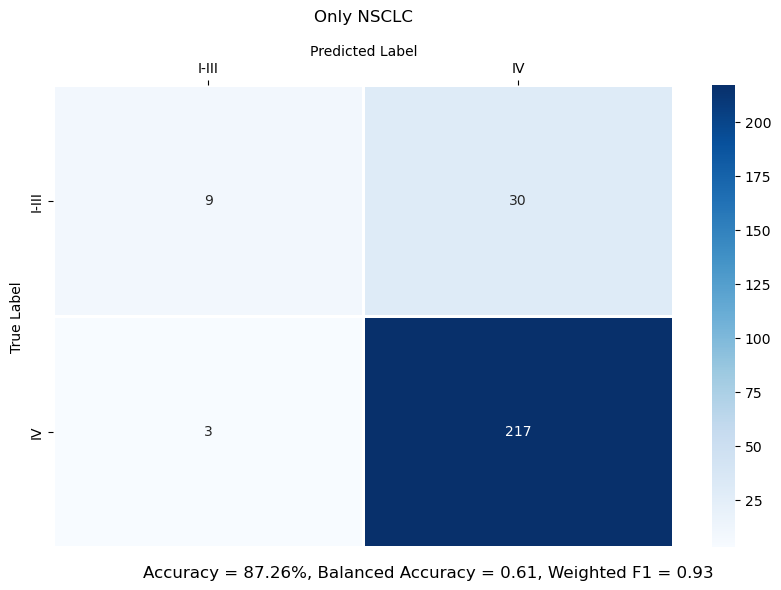

In [36]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Ovarian cancer

In [37]:
X_train = train.loc[train['Group'] == 'ovarianCancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    70
1    26
Name: Stage, dtype: int64

In [38]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 13:10:18,868] A new study created in memory with name: no-name-ac7b6c16-b21a-4611-b3b6-552dd305e069
[I 2023-10-21 13:10:21,091] Trial 0 finished with value: 0.6966036414565826 and parameters: {'n_estimators': 135, 'max_depth': 2, 'learning_rate': 0.2126695045866746, 'subsample': 0.7096269617534735, 'colsample_bytree': 0.8103128031719851, 'gamma': 1.3579309385684595}. Best is trial 0 with value: 0.6966036414565826.
[I 2023-10-21 13:10:23,507] Trial 1 finished with value: 0.7743930905695612 and parameters: {'n_estimators': 116, 'max_depth': 8, 'learning_rate': 0.3172083672486957, 'subsample': 0.6740374469918647, 'colsample_bytree': 0.512658484244354, 'gamma': 0.6852175810579691}. Best is trial 1 with value: 0.7743930905695612.
[I 2023-10-21 13:10:25,782] Trial 2 finished with value: 0.713468720821662 and parameters: {'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.36714113158549244, 'subsample': 0.8204738984447727, 'colsample_bytree': 0.7649041854367616, 'gamma': 4.

[I 2023-10-21 13:11:05,185] Trial 25 finished with value: 0.8269724556489262 and parameters: {'n_estimators': 62, 'max_depth': 5, 'learning_rate': 0.06060837839983123, 'subsample': 0.7675956577568785, 'colsample_bytree': 0.6104384080822197, 'gamma': 1.9342117388755398}. Best is trial 25 with value: 0.8269724556489262.
[I 2023-10-21 13:11:07,025] Trial 26 finished with value: 0.7644724556489262 and parameters: {'n_estimators': 59, 'max_depth': 3, 'learning_rate': 0.047860983815877715, 'subsample': 0.8361294345176259, 'colsample_bytree': 0.6432471297289956, 'gamma': 1.8653573174689795}. Best is trial 25 with value: 0.8269724556489262.
[I 2023-10-21 13:11:08,970] Trial 27 finished with value: 0.7912581699346406 and parameters: {'n_estimators': 66, 'max_depth': 4, 'learning_rate': 0.06065116557899958, 'subsample': 0.7856696671441168, 'colsample_bytree': 0.5897922405046636, 'gamma': 0.3929232247201182}. Best is trial 25 with value: 0.8269724556489262.
[I 2023-10-21 13:11:10,924] Trial 28 fi

[I 2023-10-21 13:11:53,365] Trial 50 finished with value: 0.8091153127917834 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.02315388753371756, 'subsample': 0.7756299955781002, 'colsample_bytree': 0.5249863881102032, 'gamma': 1.0468878548836822}. Best is trial 34 with value: 0.8339169000933706.
[I 2023-10-21 13:11:54,524] Trial 51 finished with value: 0.8200280112044818 and parameters: {'n_estimators': 28, 'max_depth': 7, 'learning_rate': 0.1171540400979167, 'subsample': 0.7225512184083985, 'colsample_bytree': 0.5013064219855937, 'gamma': 1.286283906520678}. Best is trial 34 with value: 0.8339169000933706.
[I 2023-10-21 13:11:55,664] Trial 52 finished with value: 0.7952264239028944 and parameters: {'n_estimators': 25, 'max_depth': 8, 'learning_rate': 0.1024112999684649, 'subsample': 0.700711900883566, 'colsample_bytree': 0.5005404632792712, 'gamma': 1.8667492330585806}. Best is trial 34 with value: 0.8339169000933706.
[I 2023-10-21 13:11:57,035] Trial 53 finish

[I 2023-10-21 13:12:33,864] Trial 75 finished with value: 0.7952264239028946 and parameters: {'n_estimators': 121, 'max_depth': 5, 'learning_rate': 0.11096103934822257, 'subsample': 0.7371866304647534, 'colsample_bytree': 0.5290267558618762, 'gamma': 1.2162269352782138}. Best is trial 34 with value: 0.8339169000933706.
[I 2023-10-21 13:12:35,303] Trial 76 finished with value: 0.8160597572362278 and parameters: {'n_estimators': 36, 'max_depth': 6, 'learning_rate': 0.08226500086327702, 'subsample': 0.6998077545401526, 'colsample_bytree': 0.5605180167673026, 'gamma': 0.14919222630563345}. Best is trial 34 with value: 0.8339169000933706.
[I 2023-10-21 13:12:36,961] Trial 77 finished with value: 0.8269724556489262 and parameters: {'n_estimators': 47, 'max_depth': 4, 'learning_rate': 0.06578670545986534, 'subsample': 0.7555876672686271, 'colsample_bytree': 0.541416598874179, 'gamma': 0.3787057640748196}. Best is trial 34 with value: 0.8339169000933706.
[I 2023-10-21 13:12:38,719] Trial 78 fi

In [39]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.85      0.96      0.90        70
          IV       0.82      0.54      0.65        26

    accuracy                           0.84        96
   macro avg       0.84      0.75      0.78        96
weighted avg       0.84      0.84      0.83        96



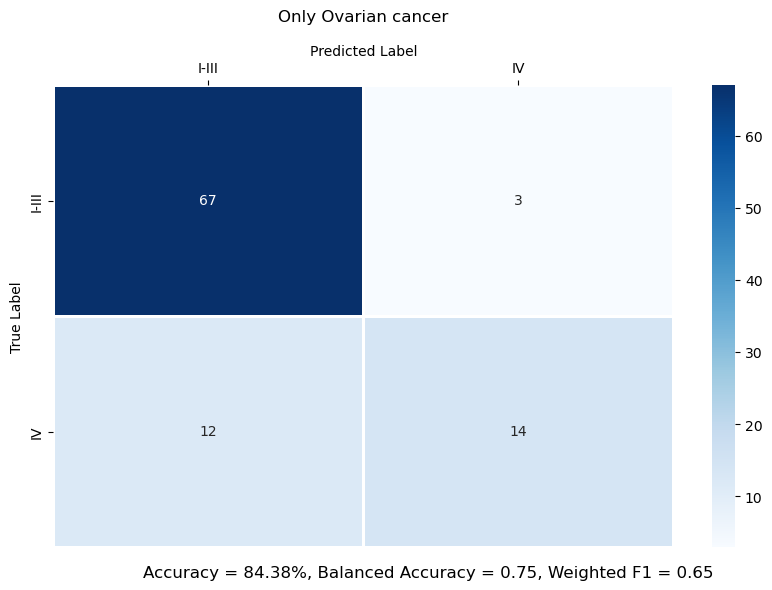

In [40]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### PDAC

In [41]:
X_train = train.loc[train['Group'] == 'PDAC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    74
1    19
Name: Stage, dtype: int64

In [42]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 13:13:10,098] A new study created in memory with name: no-name-97e8a15e-6070-42de-bf93-c9f4bbb9be02
[I 2023-10-21 13:13:11,325] Trial 0 finished with value: 0.5173611111111112 and parameters: {'n_estimators': 24, 'max_depth': 8, 'learning_rate': 0.2514437254289941, 'subsample': 0.7802296047562476, 'colsample_bytree': 0.8642931373131394, 'gamma': 0.23543102747695888}. Best is trial 0 with value: 0.5173611111111112.
[I 2023-10-21 13:13:12,874] Trial 1 finished with value: 0.4930555555555556 and parameters: {'n_estimators': 37, 'max_depth': 5, 'learning_rate': 0.046733239091097674, 'subsample': 0.7118813724658815, 'colsample_bytree': 0.943913210410781, 'gamma': 1.587647836520496}. Best is trial 0 with value: 0.5173611111111112.
[I 2023-10-21 13:13:14,227] Trial 2 finished with value: 0.5048611111111111 and parameters: {'n_estimators': 46, 'max_depth': 2, 'learning_rate': 0.22512069138993368, 'subsample': 0.8802513998241945, 'colsample_bytree': 0.5844674051699199, 'gamma': 1.

[I 2023-10-21 13:14:00,199] Trial 25 finished with value: 0.5680555555555555 and parameters: {'n_estimators': 36, 'max_depth': 2, 'learning_rate': 0.2789764487837601, 'subsample': 0.9423429796957746, 'colsample_bytree': 0.6958048764067475, 'gamma': 0.5163102486658406}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:14:01,563] Trial 26 finished with value: 0.5229166666666667 and parameters: {'n_estimators': 35, 'max_depth': 2, 'learning_rate': 0.29495524723477756, 'subsample': 0.9349403390995389, 'colsample_bytree': 0.6810924995509495, 'gamma': 0.4957050951620897}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:14:02,626] Trial 27 finished with value: 0.5229166666666667 and parameters: {'n_estimators': 20, 'max_depth': 2, 'learning_rate': 0.3256909951621598, 'subsample': 0.8847948269013836, 'colsample_bytree': 0.5987886533161151, 'gamma': 0.5665597538623667}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:14:04,397] Trial 28 finished with value: 0.479861111111111

[I 2023-10-21 13:14:38,877] Trial 51 finished with value: 0.5430555555555555 and parameters: {'n_estimators': 40, 'max_depth': 8, 'learning_rate': 0.28506778091654417, 'subsample': 0.9463454704264277, 'colsample_bytree': 0.6535178838427755, 'gamma': 1.9590790709166086}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:14:40,481] Trial 52 finished with value: 0.5493055555555556 and parameters: {'n_estimators': 54, 'max_depth': 7, 'learning_rate': 0.3365171851450689, 'subsample': 0.9715446433813656, 'colsample_bytree': 0.6914086939796644, 'gamma': 2.109711826247167}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:14:41,677] Trial 53 finished with value: 0.5368055555555555 and parameters: {'n_estimators': 27, 'max_depth': 7, 'learning_rate': 0.2955504354919832, 'subsample': 0.9442050482356532, 'colsample_bytree': 0.6731122429253444, 'gamma': 1.775265983324876}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:14:43,131] Trial 54 finished with value: 0.55 and parameters

[I 2023-10-21 13:15:16,125] Trial 77 finished with value: 0.54375 and parameters: {'n_estimators': 63, 'max_depth': 2, 'learning_rate': 0.3220138311051507, 'subsample': 0.9996191836240185, 'colsample_bytree': 0.738568582801609, 'gamma': 0.6658266622646143}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:15:17,813] Trial 78 finished with value: 0.5611111111111111 and parameters: {'n_estimators': 60, 'max_depth': 2, 'learning_rate': 0.35581053338471835, 'subsample': 0.9703256520100292, 'colsample_bytree': 0.7818457147183433, 'gamma': 0.8588226845070965}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:15:19,558] Trial 79 finished with value: 0.5361111111111111 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.3413299699868633, 'subsample': 0.9826535166119583, 'colsample_bytree': 0.7512187614377164, 'gamma': 0.36423599266055073}. Best is trial 24 with value: 0.58125.
[I 2023-10-21 13:15:21,265] Trial 80 finished with value: 0.58125 and parameters: {'n_

In [43]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.79      0.97      0.87        74
          IV       0.00      0.00      0.00        19

    accuracy                           0.77        93
   macro avg       0.40      0.49      0.44        93
weighted avg       0.63      0.77      0.69        93



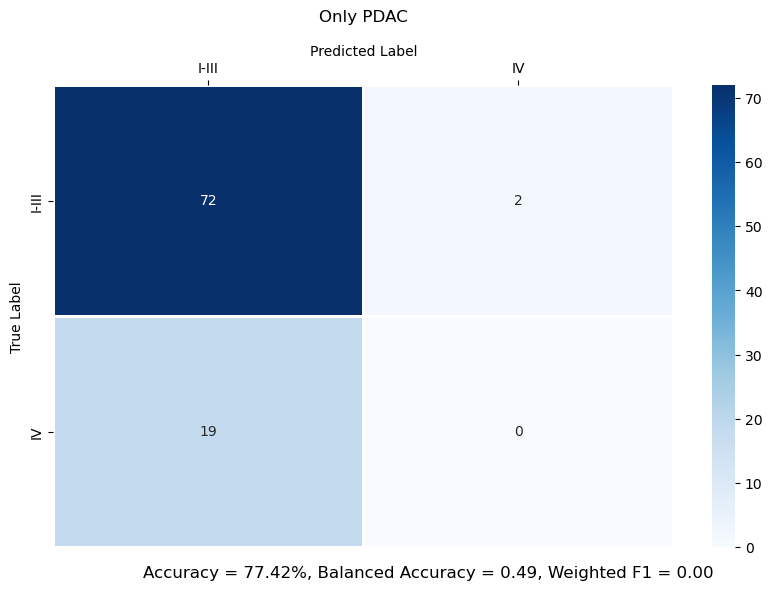

In [44]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pdac_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))